In [1]:
import SimpleITK as sitk
from viz import *
from clinical_evaluation import preprocess, pipeline, metrics

In [2]:
pipeline = pipeline.EvaluationPipeline()

In [3]:
# Load planning CT
CT = pipeline.load("/home/suraj/Repositories/data/cervix-eval/CT/21700691/0/CT.nrrd")

# Load masks of interest
# bladder_mask = pipeline.load("/home/suraj/Repositories/data/cervix-eval/CT/21700691/0/BLADDER.nrrd")
# bowel_mask = pipeline.load("/home/suraj/Repositories/data/cervix-eval/CT/21700691/0/BOWELAREA.nrrd")

In [4]:
CT = pipeline.apply_body_mask(CT)

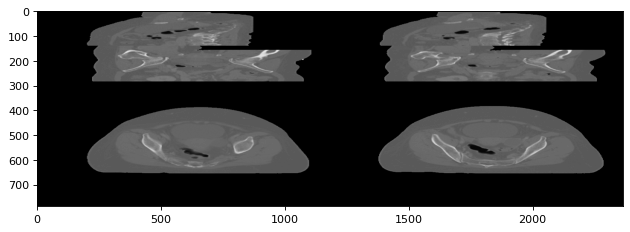

In [5]:
show_mid_slices(CT)

In [6]:
# # Resample masks to image spacing
# bowel_mask = preprocess.resample_image_to_spacing(bowel_mask, CT.GetSpacing(), default_value=0, interpolator='nearest')
# bladder_mask = preprocess.resample_image_to_spacing(bladder_mask, CT.GetSpacing(), default_value=0, interpolator='nearest')

In [7]:
# Load first CBCT in the sequence of CBCTS
CBCT = pipeline.load("/home/suraj/Repositories/data/cervix-eval/CBCT/21700691/X01.nrrd")
CBCT = preprocess.hu_correction(CBCT)
CBCT = pipeline.apply_body_mask(CBCT, -700)

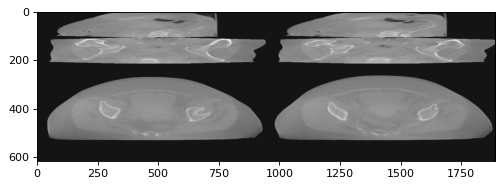

In [8]:
show_mid_slices(CBCT)

In [9]:
# Load synthetic/ generated CT
sCT = pipeline.load("/home/suraj/Repositories/data/cervix-eval/sCT/21700691/X01.nrrd")

# Generated sCT can have smaller zdims due to fov truncation, use resample to match CBCT
CBCT = sitk.Resample(CBCT,
                         sCT.GetSize(),             # size
                         sitk.Transform(),     # transform
                         sitk.sitkLinear,         # interpolator
                         sCT.GetOrigin(),    # outputOrigin
                         sCT.GetSpacing(),          # outputSpacing
                         sCT.GetDirection(), # outputDirection
                         -1024,        # defaultPixelValue
                         sCT.GetPixelID()) 

In [10]:
# Custom cylinder mask code

# # Generate FOV mask cylinder based on thresholding + hole filling
# fill_holes = sitk.VotingBinaryHoleFillingImageFilter()
# fov_mask = fill_holes.Execute(CBCT!=-1024)
# sitk.WriteImage(fov_mask, "fov_mask.nrrd", True)

### SimpleElastix Registration Process


In [11]:
# Perform deformable registration
dpCT, elastixImageFilter = pipeline.deform(CT, CBCT, None)

In [12]:
dpCT = sitk.Cast(dpCT, sitk.sitkInt16)

In [13]:
# bladder_mask = sitk.Cast(sitk.Transformix(bladder_mask, elastixImageFilter.GetTransformParameterMap()), sitk.sitkInt8)

In [14]:
abs_diff_CBCT = metrics.get_abs_diff(CBCT, dpCT)

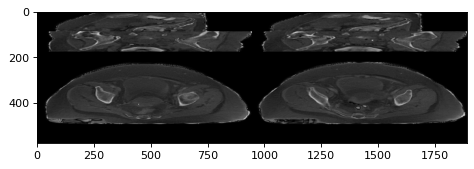

In [15]:
show_mid_slices(abs_diff_CBCT)

In [16]:
metrics.get_statistics(abs_diff_CBCT)

----- REPORT --------
 Mean: 141.5582448259727 
             Max: 2702.0 
 Min: 0.0 
 Variance: 26469.04933425073


In [17]:
# dpCT = pipeline.deform(CT, sCT, None)
# dpCT = sitk.Cast(dpCT, sitk.sitkInt16)
abs_diff_sCT = metrics.get_abs_diff(sCT, dpCT)
metrics.get_statistics(abs_diff_sCT)

----- REPORT --------
 Mean: 68.50797682035777 
             Max: 2702.0 
 Min: 0.0 
 Variance: 18029.894181541007


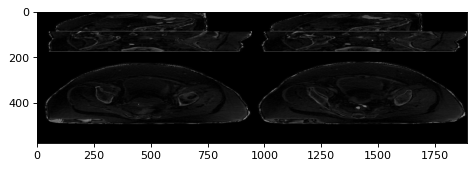

In [18]:
show_mid_slices(abs_diff_sCT)

In [19]:
sitk.WriteImage(CBCT, "CBCT1.nrrd", True)
sitk.WriteImage(dpCT, "dpCT1.nrrd", True)
sitk.WriteImage(CT, "pCT1.nrrd", True)
sitk.WriteImage(sCT, "sCT1.nrrd", True)
sitk.WriteImage(abs_diff_CBCT, "abs_diff_CBCT1.nrrd", True)
sitk.WriteImage(abs_diff_sCT, "abs_diff_sCT1.nrrd", True)
